# Comparison of accuracy on congruent vs. incongruent trials

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import binom_test
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
import statsmodels
statsmodels.__version__

'0.13.5'

In [3]:
def load_results(results_fn, result_type= 'accuracy', rep_name = ''):
    """
        Function to load the results
            - result_fn: the path to the result folder
            - result_type: whether loading 'accuracy' result or 'warping' (distance ratio) result
            - rep_name: what type of representation to use (e.g, the averaged representations)
    """
    results_dir = '../results/'
    results_path = os.path.join(results_dir,results_fn)
    
    with open(results_path, 'rb') as f:
        data = pickle.load(f)
    
    if result_type == 'accuracy':
        results = data['results']
        accs = []
        cong_accs = []
        incong_accs = []
        for run in results:
            accs.append([s['acc'] for s in run['analyze_accs']])
            cong_accs.append([s['cong_acc'] for s in run['analyze_accs']])
            incong_accs.append([s['incong_acc'] for s in run['analyze_accs']])
        accs = np.array(accs)
        cong_accs = np.array(cong_accs)
        incong_accs = np.array(incong_accs)
        return accs, cong_accs, incong_accs
    elif result_type == 'warping':
        # Get ratio results
        analysis = data['analysis']
        ratios = []
        for run in analysis:
            ratios.append([s['distance_ratio'][rep_name]['ratio'] for s in run])
        dist_ratios = np.array(ratios)
        
        return dist_ratios

In [4]:
def plot_accuracy(cong_accs, incong_accs, cong_p, incong_p, 
                  logistic_p, analyze_every, title, save_fn, 
                  sig_threshold=0.001, include_sig_points= False):
    """
        Function to plot the accuracy results:
            - cong_accs: accuracy of the congruent pair of faces
            - incong_accs: accuracy of the incongruent pair of faces
            - cong_p: p_values corresponding to steps at which the accuracy of 
                      congruent pair of faces is significantly different from chance 
            - incong_p: p_values corresponding to steps at which the accuracy of 
                      incongruent pair of faces is significantly different from chance 
            - logistic_p: p_values corresponding to steps at which the accuracy of
                          congruent pair of faces is significantly different from the 
                          accuracy of incongruent pair of faces
            - analyze_every: perform the analysis every "analyze_every" steps
            - title: title for the plot
            - save_fn: filename to save the result
            - sig_threshold: a therehsold to select significant points 
                             according to the logistic regression
            - include_sig_points: whether adding "x" marks at steps in which the accuracy 
                                  is significanly different from chance
    """
    n_runs, n_checkpoints = cong_accs.shape

    # Compute mean and standard deviation for error bars
    cong_mean = np.mean(cong_accs, axis=0)
    incong_mean = np.mean(incong_accs, axis=0)

    cong_sem = np.std(cong_accs, axis=0) / np.sqrt(len(cong_accs))
    incong_sem = np.std(incong_accs, axis=0) / np.sqrt(len(incong_accs))

    # Plot
    fig, ax = plt.subplots()
    x = np.arange(n_checkpoints)*analyze_every
    ax.errorbar(x, cong_mean, yerr=cong_sem, c='tab:green')
    ax.errorbar(x, incong_mean, yerr=incong_sem, c='tab:orange')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.ylim([-0.1,1.1])
    plt.title("Accuracy on congruent trials improves first")
    ax.legend(["Congruent", "Incongruent"])
    plt.axhline(y=0.5, color='black', linestyle='--')
    
    # Get spans of significance according to logistic regression
    significant = [p < sig_threshold for p in logistic_p]
    sig_spans = []
    mid_span = False
    current_idx = 0
    while current_idx < len(significant):
        if mid_span:
            if not significant[current_idx]:
                stop = current_idx - 1
                sig_spans.append([start, stop])
                mid_span = False
        else:
            if significant[current_idx]:
                start = current_idx
                mid_span = True
        current_idx += 1
        
    # Convert spans from idxs to steps
    sig_spans = [[start*analyze_every, stop*analyze_every] for start, stop in sig_spans]
    
    # Visualize significance with colored area
    for span in sig_spans:
        plt.axvspan(span[0], span[1], color='blue', alpha=0.1)
    
    if include_sig_points:
        # Add asterisks for significance level
        for i in range(n_checkpoints):
            x_coord = x[i]
            y_coord_cong = cong_mean[i]
            y_coord_incong = incong_mean[i]
            if cong_p[i] < 0.05:
                plt.plot(x_coord, y_coord_cong, marker='x', color='blue')
            if incong_p[i] < 0.05:
                plt.plot(x_coord, y_coord_incong, marker='x', color='blue')
        
    
    # Save figure
    if save_fn is not None:
        plt.savefig(save_fn, dpi=1000, format='eps', bbox_inches='tight')
        
    plt.show()

In [5]:
def make_tsv(model_name = 'rnn'):
    """
        Funciton to save the results as a tsv file
        - model_name: what model to use 
    """
    in_dir = '../results/' #'Path to results directory with pickle files
    out_dir = '../results/tsv/' #Path to directory to output tsv files
    # Make output directory
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    # Load basic results
    fn = os.path.join(in_dir, f"{model_name}.P")
    with open(fn, 'rb') as f:
        results = pickle.load(f)

    # Accuracy results
    header = []
    data = []
    acc_results = results['results']
    for run_i, run in enumerate(acc_results):
        for acc_type in ['acc', 'cong_acc', 'incong_acc']:
            # Get column of data
            col = np.array([s[acc_type] for s in run['analyze_accs']])
            col = np.expand_dims(col, axis=1)
            data.append(col)

            # Header
            run_name = f"run{run_i}"
            acc_name = acc_type.replace('_', '-')
            head = f"{run_name}_{acc_name}"
            header.append(head)

    data = np.asarray(data).squeeze()
    print(data.shape, type(data))
    header = "\t".join(header)
    out_file = os.path.join(out_dir, f'acc_{model_name}.tsv')
    print(f"Writing accuracy results to {out_file}")
    header_len = len(header.split('\t'))
    print(f"Shape = {data.shape}, header = {header_len}")
    np.savetxt(out_file, data, delimiter='\t', header=header)

In [6]:
def binomial_test(accs):
    """
        Test whether accuracies are significantly different from chance
        Binomial test assuming that samples from all runs are i.i.d.
        384 samples (96 neutral, 144 congruent, 144 incongruent)
            - accs: accuracy values 
    """
    n = 144
    n_runs, n_checkpoints = accs.shape
    N = n*n_runs # total number of trials
    
    # Convert accuracies to successes
    successes = accs * n
    assert all([s.is_integer() for s in successes.flatten()])
    successes = np.sum(successes, axis=0)
    
    # Binomial test
    p_vals = []
    for s in successes:
        p_val = binom_test(s, N, p=0.5)
        p_vals.append(p_val)
    
    return p_vals # n_steps
    

## Accuracies on all samples

In [7]:
results_fn = 'rnn.P'
rep_name = ''
analyze_every = 50
accs_type = 'analyze_accs'
result_type= 'accuracy'
title = "RNN"
save_fn = '../figures/rnn_logistic_regression_cong_vs_incong_p001.eps'

Loading the results of the accuracy for all, congruent, incongruent pairs

In [8]:
accs, cong_accs, incong_accs = load_results(results_fn, result_type, rep_name)

Binomial test to test whether accuracy is significantly different from chance

In [9]:
cong_p = binomial_test(cong_accs)
incong_p = binomial_test(incong_accs)

Logistic regression to test difference between congruent and incongruent accuracy

In [10]:
# Convert accuracies to correct
assert incong_accs.shape == cong_accs.shape
n_runs, n_steps = cong_accs.shape
n_trials = 144 # 144 congruent trials, 144 incongruent trials
#n_runs = 5

dfs = []
for step_i in range(n_steps):
    run_data = []
    for run_i in range(n_runs):
        cong_acc = cong_accs[run_i, step_i]
        incong_acc = incong_accs[run_i, step_i]
        n_cong_correct = cong_acc * n_trials
        n_incong_correct = incong_acc * n_trials
        assert n_cong_correct.is_integer()
        assert n_incong_correct.is_integer()
        n_cong_correct = int(n_cong_correct)
        n_incong_correct = int(n_incong_correct)
        cong_correct = np.ones([n_cong_correct, 1])
        cong_incorrect = np.zeros([n_trials - n_cong_correct,1])
        incong_correct = np.ones([n_incong_correct,1])
        incong_incorrect = np.zeros([n_trials - n_incong_correct,1])
        
        # make dataframe
        run_id = run_i * np.ones([2*n_trials,1])
        is_cong = np.concatenate([np.ones([n_trials,1]), 
                                  np.zeros([n_trials,1])], 
                                 axis=0)
        is_correct = np.concatenate([cong_correct, cong_incorrect,
                                     incong_correct, incong_incorrect],
                                    axis=0)
        run = np.concatenate([run_id, is_cong, is_correct], axis=1)
        run_data.append(run)
    step_data = np.concatenate(run_data, axis=0)
    col_names = ["run", "cong", "correct"]
    df = pd.DataFrame(step_data, columns=col_names)
    df["run"] = df["run"].astype("category")
    dfs.append(df)

In [11]:
%%capture
log_regs = []
for df in dfs:
    log_reg = smf.logit("correct ~ cong", data=df).fit()
    log_regs.append(log_reg)

In [12]:
# whether printing the statistical results for all the steps
print_all_steps = False

if print_all_steps:
    for step_i, log_reg in enumerate(log_regs):
        print(f"Step: {step_i*analyze_every}")
        print(log_reg.summary())
        print("\n")

In [13]:
logistic_p = [log_reg.pvalues[1] for log_reg in log_regs]
logistic_t = [log_reg.tvalues[1] for log_reg in log_regs]

Plotting the results
- Shaded area shows at what steps the accuracies are different 
  between congruent and incongruent pairs
- Set "include_sig_points" to "True" to assing "x" marks at steps
  at which the accuracy is significanly different from chance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


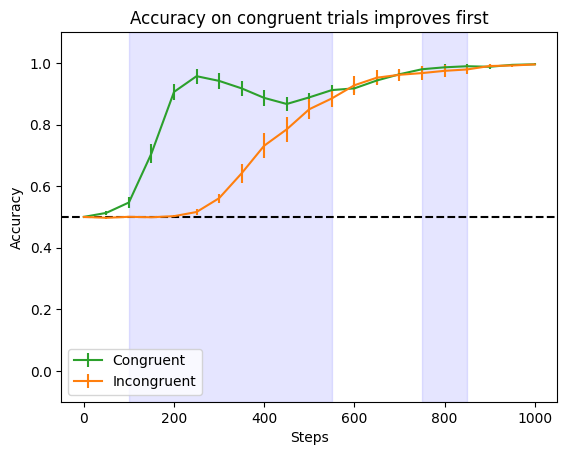

In [14]:
plot_accuracy(cong_accs, incong_accs, cong_p, incong_p, logistic_p, 
            analyze_every, title, save_fn, 
            sig_threshold=0.05, include_sig_points= False)

Save the results of the plots to a tsv file 

In [15]:
header = '\t'.join([f"Step{analyze_every*i}" for i in range(len(logistic_p))])
np.savetxt('../results/tsv/acc_rnn_logistic_p.tsv',  logistic_p, 
           delimiter='\t', header=header)
np.savetxt('../results/tsv/acc_rnn_logistic_t.tsv',  logistic_t, 
           delimiter='\t', header=header)

## Relationship between warping and congruent vs. incongruent accuracy

In [16]:
result_type = 'warping'
rep_name = 'average'

Load warping data

In [17]:
dist_ratios = load_results(results_fn, result_type, rep_name)

In [18]:
# Average over runs
ave_dist_ratios = np.mean(dist_ratios, axis=0)
ave_cong_accs = np.mean(cong_accs, axis=0)
ave_incong_accs = np.mean(incong_accs, axis=0)
ave_acc_ratios = ave_incong_accs / ave_cong_accs
lin_time = np.arange(n_steps)

Plotting the relationship between the accruacy ratio and distance ratio

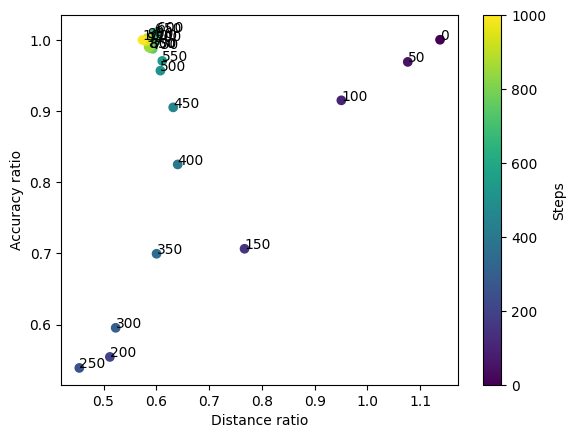

In [19]:
plt.scatter(ave_dist_ratios, ave_acc_ratios, c=analyze_every*lin_time)

labels = [analyze_every*i for i in range(len(ave_dist_ratios))]
for i, label in enumerate(labels):
    plt.annotate(label, (ave_dist_ratios[i], ave_acc_ratios[i]))

plt.xlabel("Distance ratio")
plt.ylabel("Accuracy ratio")
plt.colorbar(label="Steps")
plt.savefig('../figures/acc_vs_dist_scatter.eps', 
            dpi=1000, format='eps', bbox_inches='tight')
plt.show()

In [20]:
lin_time_ = np.expand_dims(lin_time, axis=1)
ave_dist_ratios_ = np.expand_dims(ave_dist_ratios, axis=1)
interaction = np.expand_dims(lin_time*ave_dist_ratios, axis=1)
x = np.concatenate([lin_time_, ave_dist_ratios_, interaction], axis=1)
x = sm.add_constant(x)
y = ave_acc_ratios

In [23]:
print(x.shape, y.shape)

(21, 4) (21,)


In [24]:
reg = sm.OLS(y,x).fit()

There is a significant main effect of warping (distance ratio: avg_incong_dist / avg_cong_dist)

There is a significant interaction between steps and warping (Steps*Warping)

In [25]:
print(reg.summary(xname=['Intercept', 'Steps', 'Warping', 'Steps*Warping']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     40.52
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           5.83e-08
Time:                        13:34:33   Log-Likelihood:                 30.820
No. Observations:                  21   AIC:                            -53.64
Df Residuals:                      17   BIC:                            -49.46
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1316      0.091      1.449